# Lab3. Pytorch Classification (Logistic Regression vs MLP)  

### 1. Data Generation  (Preparation)

**Data Set**  
$$X_{train} \in \mathcal{R}^{8000 \times 2}, Y_{train} \in \mathcal{Z}^{8000}$$  
$$X_{val} \in \mathcal{R}^{1000 \times 2}, Y_{val} \in \mathcal{Z}^{1000}$$  
$$X_{test} \in \mathcal{R}^{1000 \times 2}, Y_{test} \in \mathcal{Z}^{1000}$$

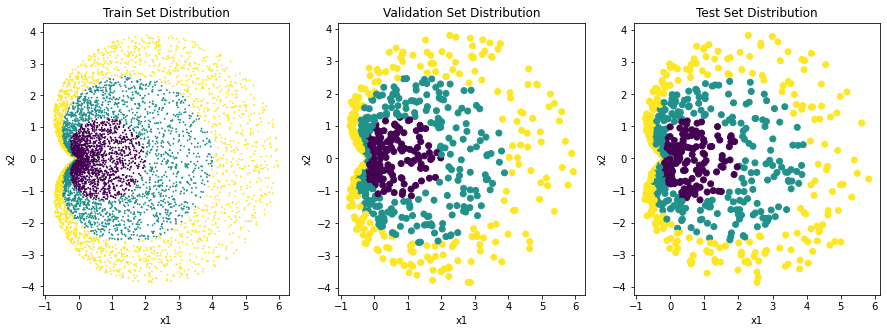

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


# ====== Generating Dataset ====== #
r = np.random.rand(10000)*3           
theta = np.random.rand(10000)*2*np.pi  
y = r.astype(int)
r = r * (np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)  # x1과 x2의 따른 scatter 분포도(색깔: class label)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')


ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')

plt.show()

### 2. Hypothesis Define (Model Define)  

In [ ]:
import torch
import torch.nn as nn

# Lab 2에서와 마찬가지로 나름대로의 MLP 모델을 구성하여 아래 시각화 결과와 같이 시각화하도록 하세요
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        # ------------------빈 칸------------------#
    
        self.fc1 = nn.Linear(2, 256)               # input: 2개(x1, x2) / 입력 layer(first): input 수, 연결하고자 하는 node의 수(선택) 
        self.fc2 = nn.Linear(256,128)              # hidden layer: first layer의 노드수, 연결하고자 하는 node의 수(256, 128)
        self.fc3 = nn.Linear(128,64)               # hidden layer: second layer의 노드수, 연결하고자 하는 node의 수(128, 64)
        self.fc4 = nn.Linear(64,16)                # hidden layer: second layer의 노드수, 연결하고자 하는 node의 수(64, 16)
        self.fc5 = nn.Linear(16,3)                 # 출력 layer: hidden layer의 마지막 node 노드의 수와 ouput(예측 label) 수
        self.ReLU = nn.ReLU()                      # 활성화 함수 정의: ReLU
        
        # -----------------------------------------#
    
    def forward(self, x):
        # ------------------빈 칸------------------#
        
        x = self.fc1(x)                            # 앞선 정의한 fully connected layer + activation function 조합
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)
        x = self.ReLU(x)
        x = self.fc5(x)
        #x = F.log_softmax(x, dim = 1)        
        
        # -----------------------------------------#
        return x

### 3. Cost Function Define (Loss Function Define)  

In [ ]:
cls_loss = nn.CrossEntropyLoss()

### 4. Train & Evaluation

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

model = MLPModel() 
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 


list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []


epoch = 8000
for i in range(epoch):
    
    # ====== Train ====== #
    model.train()                             # model train 상태로 지정 
    optimizer.zero_grad()                     # optimizer 초기화(0)
    
    input_x = torch.Tensor(train_X)           # input : array 형식 -> tensor 형식으로 변환 (8000 * 2: 8000 -> train sample 수, 2: x1, x2)
    true_y = torch.Tensor(train_y).long()     # 
    pred_y = model(input_x)                   # prediction value: 3 class의 probability (1000 * 3)

    
    loss = cls_loss(pred_y.squeeze(), true_y) # Loss 계산(질문: 왜 여기서는 squeeze()를 사용? / 결과는 나옴)
    loss.backward()                           # 역전파 계산
    optimizer.step()                          # papameter updata
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy()) # detach(): tensor의 loss 값만 지정
    
    
    # ====== Validation ====== #
    model.eval()                              # model 평가 상태로 지정 / 이외의 코드 위와 상동
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)   
    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0:                          # 8000번 epoch 별로 200번 기점으로 결과
        
        # ====== Calculate Accuracy ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() # 성능을 평가(정확도, accuracy)를 위해서 예측값을 생성
        acc = accuracy_score(true_y, pred_y) 
        list_acc.append(acc)
        list_acc_epoch.append(i)


        # epoch 별 학습 과정과 예측 정확도 변화를 시각화 -> 초반에는 하나의 클래스만 학습 점차 제대로 학습 

        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True test y')
        
        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted test y')
        
        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

Output hidden; open in https://colab.research.google.com to view.

### 5. Report Experiment  

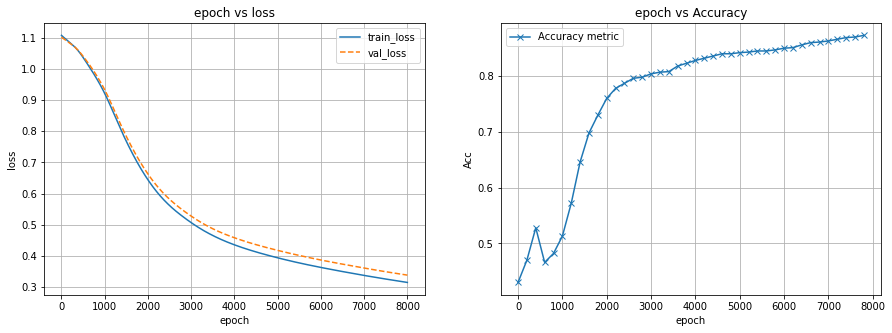

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()